## 3.1.4 Challenge: Model Comparison

You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from scipy import stats

In [2]:
data_path = '/home/mache/Desktop/Thinkful/Course/Unit 3/GBRIDXGBP_15 Mins_Bid_2017.10.01_2018.04.01.csv'
df = pd.read_csv(data_path)[['Time (ART)','Open', 'High', 'Low', 'Close']]
display(df.shape)
display(df.head(3))

(12480, 5)

Time (ART)      Open      High       Low     Close
0  2017.10.01 18:00:00  7374.969  7374.969  7374.969  7374.969
1  2017.10.01 18:15:00  7374.969  7374.969  7374.969  7374.969
2  2017.10.01 18:30:00  7374.969  7374.969  7374.969  7374.969

In [3]:
df.describe()

Open          High           Low         Close
count  12480.000000  12480.000000  12480.000000  12480.000000
mean    7417.746102   7420.042335   7415.386699   7417.709764
std      209.611137    208.999603    210.277273    209.629732
min     6858.100000   6865.600000   6851.609000   6858.349000
25%     7249.550000   7251.400000   7244.764000   7249.512250
50%     7458.770000   7459.800000   7456.770000   7458.770000
75%     7549.269000   7552.270000   7548.269250   7549.269000
max     7788.969000   7792.770000   7786.269000   7788.770000

### Adding the Commodity Channel Index (CCI) to our dataset

In [4]:
# Commodity Channel Index 
def CCI(df, ndays): 
 TP = (df['High'] + df['Low'] + df['Close']) / 3 
 CCI = pd.Series((TP - pd.rolling_mean(TP, ndays)) / (0.015 * pd.rolling_std(TP, ndays)),
 name = 'CCI') 
 df = df.join(CCI) 
 return df

In [5]:
# Compute the Commodity Channel Index(CCI) for FTSE100 based on the 20-day Moving average
n = 20
FTSE_CCI = CCI(df, n)
CCI = FTSE_CCI['CCI']

/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  after removing the cwd from sys.path.
/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  after removing the cwd from sys.path.


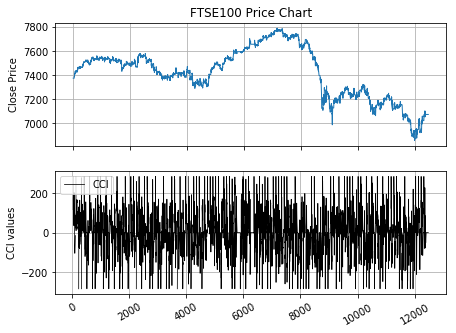

In [6]:
# Plotting the Price Series chart and the Commodity Channel index below
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
plt.plot(df['Close'],lw=1)
plt.title('FTSE100 Price Chart')
plt.ylabel('Close Price')
plt.grid(True)
bx = fig.add_subplot(2, 1, 2)
plt.plot(CCI,'k',lw=0.75,linestyle='-',label='CCI')
plt.legend(loc=2,prop={'size':10})
plt.ylabel('CCI values')
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)
plt.show()

In [7]:
df = pd.concat([df, CCI], axis=1)

In [8]:
df2 = df.replace([np.inf, -np.inf], np.nan)

In [9]:
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(subset=["CCI"], how="all")

In [10]:
df2.head(5)

Time (ART)      Open     High       Low     Close         CCI
36  2017.10.02 03:00:00  7383.969  7385.47  7380.769  7383.969  283.235277
37  2017.10.02 03:15:00  7384.269  7386.27  7382.269  7384.469  205.978172
38  2017.10.02 03:30:00  7384.269  7386.77  7382.770  7382.770  157.661018
39  2017.10.02 03:45:00  7382.969  7384.47  7379.770  7384.269  114.071201
40  2017.10.02 04:00:00  7383.970  7391.77  7373.969  7390.969  136.717910

In [11]:
df2.describe()

Open          High           Low         Close           CCI
count  12318.000000  12318.000000  12318.000000  12318.000000  12318.000000
mean    7417.580891   7419.907322   7415.190458   7417.544075      2.019403
std      210.942122    210.328114    211.610718    210.960813     81.860573
min     6858.100000   6865.600000   6851.609000   6858.349000   -283.235277
25%     7245.276500   7250.704750   7241.040000   7245.021500    -42.918377
50%     7458.770000   7461.270000   7458.119000   7458.770000      0.000007
75%     7551.470000   7552.969000   7549.269000   7551.419250     47.231402
max     7788.969000   7792.770000   7786.269000   7788.770000    283.235280

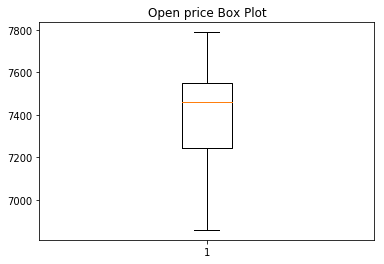

In [12]:
#Plot outcome variable
plt.boxplot(df2['Open'])
plt.title("Open price Box Plot")
plt.show()

In [13]:
#Define X and Y
X = df2[['High', 'Low', 'Close','CCI']]
Y = df2['Open']

## OLS Regression¶

In [14]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form

linear_formula = "Open ~ High + Low + Close + CCI"

# Fit the model to our data using the formula.
ftse_model = smf.ols(formula=linear_formula, data=df2).fit()

R-squared Accuracy: 0.9992 (+/- 0.0012)

Parameters

 Intercept   -1.589643
High         0.822022
Low          0.747771
Close       -0.569597
CCI         -0.005269
dtype: float64

P-values

 Intercept    2.648419e-02
High         0.000000e+00
Low          0.000000e+00
Close        0.000000e+00
CCI          1.073122e-99
dtype: float64

Confidence Intervals


0         1
Intercept -2.993664 -0.185622
High       0.811699  0.832345
Low        0.737775  0.757766
Close     -0.585133 -0.554061
CCI       -0.005751 -0.004786

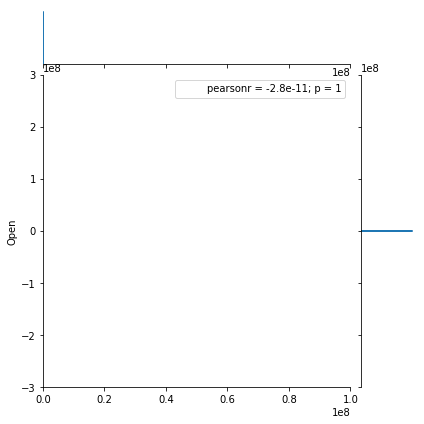

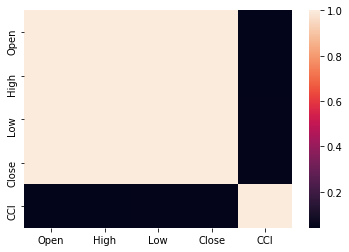

In [15]:
#5 fold cross validation for r-squared
sk_ftse_model = linear_model.LinearRegression()
score = cross_val_score(sk_ftse_model, X, Y, cv=5)
print("R-squared Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

#Check parameters
print ("\nParameters\n\n", ftse_model.params)

#Verify low p-values and confidence intervals to keep features
print ("\nP-values\n\n", ftse_model.pvalues)
print ("\nConfidence Intervals")
display(ftse_model.conf_int())

#Residuals
ols_ypred = ftse_model.predict()
ols_residual = ols_ypred - Y

sns.jointplot(ols_ypred, ols_residual, kind = 'kde', xlim = [0,100000000], ylim = [-300000000,300000000])
plt.show()

sns.heatmap(df2.corr())
plt.show()

## KNN Regression¶

Nearest neighbors: 5
R-squared Accuracy: 0.9364 (+/- 0.1725)
Nearest neighbors: 15
R-squared Accuracy: 0.9089 (+/- 0.2595)
Nearest neighbors: 25
R-squared Accuracy: 0.8960 (+/- 0.2958)
Nearest neighbors: 35
R-squared Accuracy: 0.8867 (+/- 0.3162)
Nearest neighbors: 45
R-squared Accuracy: 0.8774 (+/- 0.3345)
Nearest neighbors: 55
R-squared Accuracy: 0.8677 (+/- 0.3563)
Nearest neighbors: 65
R-squared Accuracy: 0.8588 (+/- 0.3756)


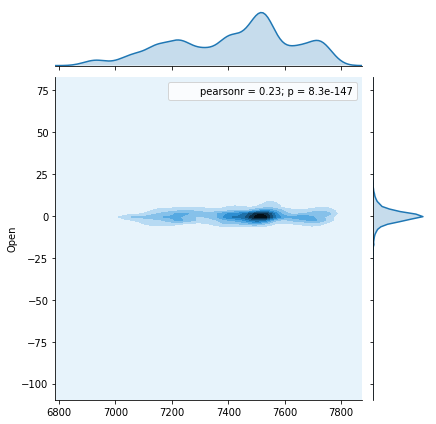

In [16]:
# Our input data frame will be the z-scores this time instead of raw data.
X_norm = X.apply(stats.zscore)
for k in range(5,75,10):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn.fit(X_norm,Y)
    knn_ypred = knn.predict(X_norm)
    score = cross_val_score(knn, X_norm, Y, cv=5)
    print ("Nearest neighbors: {}".format(k))
    print("R-squared Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))
# best k is 25
knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform')
knn.fit(X_norm,Y)
knn_ypred = knn.predict(X_norm)
knn_residual = Y - knn_ypred
sns.jointplot(knn_ypred, knn_residual, kind = "kde")
plt.show()